# __Divide a domains in sub-domains__

### Problem statement

Most domain have spatial properties, dividing a domain into multiple fracture domains will let us take into account these properties.

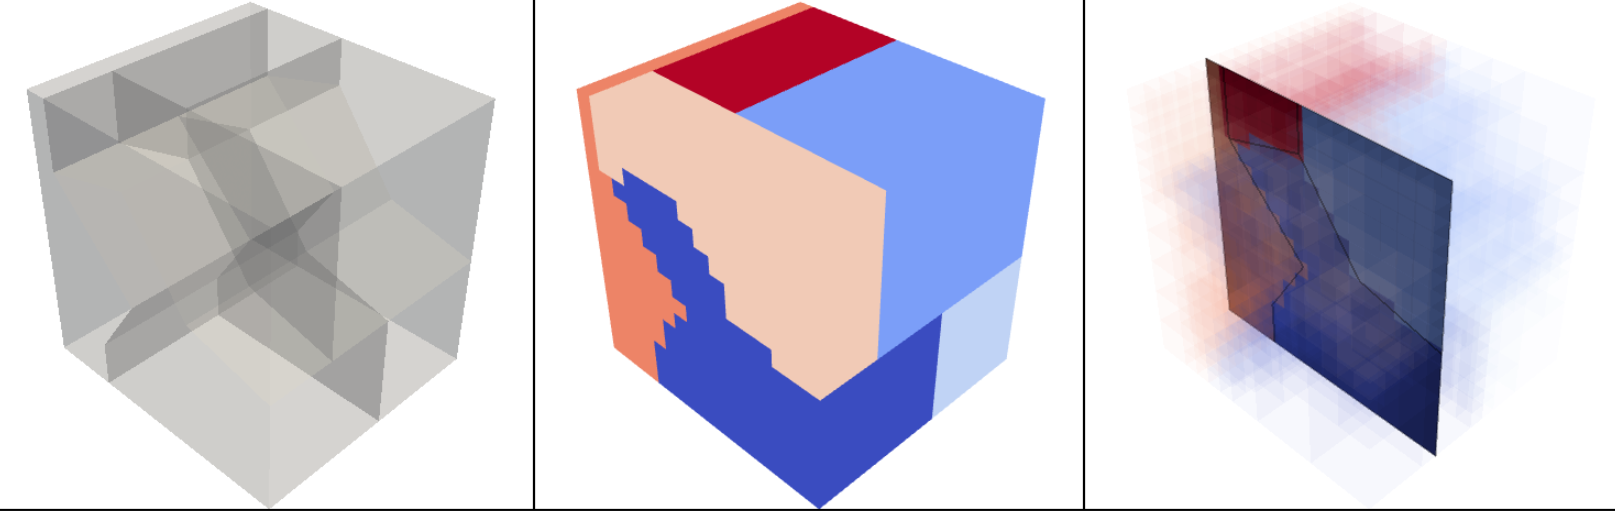

### What will you learn ?
- Add stl volume to describe a system
- Translate and rotate your fracture domains
- Create an octree to discretize space

### DFN.Lab model

Prerequisites:
* Create_domain

In this tutorial, we will explain how to take into account spatial properties

The required modules are __DataAnalysis__ and __Basis__.
<br>
We use [_pyvista_](https://docs.pyvista.org) for embedded visualization of generated networks in our notebook.
<br>
Plot functions are implemented in [Tutorials/sources/functions.py](https://gitlab.com/fractorylab/dfnlab/-/blob/new_tutos/Tutorials/sources/functions.py).

In [1]:
import dfnlab.Basis as dfn
import dfnlab.DataAnalysis as dfn_data
import os

________________________

## Import STL volumes and reposition

The example is based on a parallelepiped (110,120,120) divide in 6 domains.

It is not mandatory to position your stl files at the origin but take it into account when creating your system.


In [2]:
stlReaders = []

for i in range(1,7) :
    #Import the domain from an stl
    reader = dfn_data.STLReader("./sources/STL-Example/dom"+str(i)+".stl")
    #Translate the domain at the origin (depend of your stl definition)
    reader.translate((5, 30, 60));
    #If you need you can also rotate your volumes using reader.rotate(axis, angle)
    stlReaders.append(reader)


## Create the fracture domains

A fracture domain is the combinaison of an stl volume and properties



In [3]:
density=0;
fractureDomains = []
for reader in stlReaders :
    
    #Create properties for the domain
    density = density + 0.1
    prop = dfn.PoissonProperties()
    prop.setPositionsUniform()
    prop.setSizesPowerlaw(3,1)
    prop.setOrientationsUniform() #(180.*(float(i)/6.), 180.*(float(i)/6.), 100.);
    prop.setStopDensity(density) #The weight used in UFMGeneration to compute the pourcentage of chance to sample the domain in which the nuclei will be added  
    
    #Create a fracture domain
    fractureDomain = dfn.FractureDomain(reader.getIrregularDomain(),prop)
    fractureDomains.append(fractureDomain)
    

## Create the System and add your fracture Domains
Define the center according to your stl files, here we have reposition our files in order to have the center at [0,0,0]. 

Define the dimension L1,L2,L3 according to the volume you want to modelize, here we cover the whole stl volume

In [4]:
system = dfn.System()
system.buildParallelepiped(center=[0, 0, 0], L1=110,L2=120,L3=120) 
for fractureDomain in fractureDomains :
    system.addFractureDomain(fractureDomain)

## Create an Octree
The Octree is a data structure that discretize the volume according to the fracture domains. We need to provide a depth limit (the refinement level of the octree, the larger, the more precise the discretization)
* Function : populateOctree(int DepthLimit)
* DepthLimit : determine the size of our voxels (ie the precision of our space discretisation)




In [5]:
system.populateOctree(4)

path = os.getcwd()
fileName = os.getcwd()+"/Tmp/OctreeExample/6domainsLvl4.octree"
system.saveOctree(fileName)

## Access the property of a position in space
The Octree let you acess the property of any area of the system

In [6]:
print("The generation properties at position [0,6,3] is :", system.getProperties(position=[0,6,3]).getGenerationProperties().getParam())
print("The density at position [0,6,3] is :", system.getProperties(position=[0,6,3]).getDensity())
print("The density at position [-20,-10,80] is :", system.getProperties(position=[-20,-10,80]).getDensity())

The generation properties at position [0,6,3] is : {'avoid_finite_size_effects': '0', 'orientation_distribution': 'uniform_sphere', 'position_distribution': 'uniform_double', 'position_maxx': '0.000000', 'position_maxy': '0.000000', 'position_maxz': '0.000000', 'position_minx': '0.000000', 'position_miny': '0.000000', 'position_minz': '0.000000', 'size_a': '3.000000', 'size_distribution': 'power', 'size_max': '8999999999999999948859130765266355329578537025198862586562510896759102769772101980841694466750283776.000000', 'size_min': '1.000000', 'stop_condition': 'density', 'stop_value': '0.100000'}
The density at position [0,6,3] is : 0.1
The density at position [-20,-10,80] is : 0.6


## Visualisation

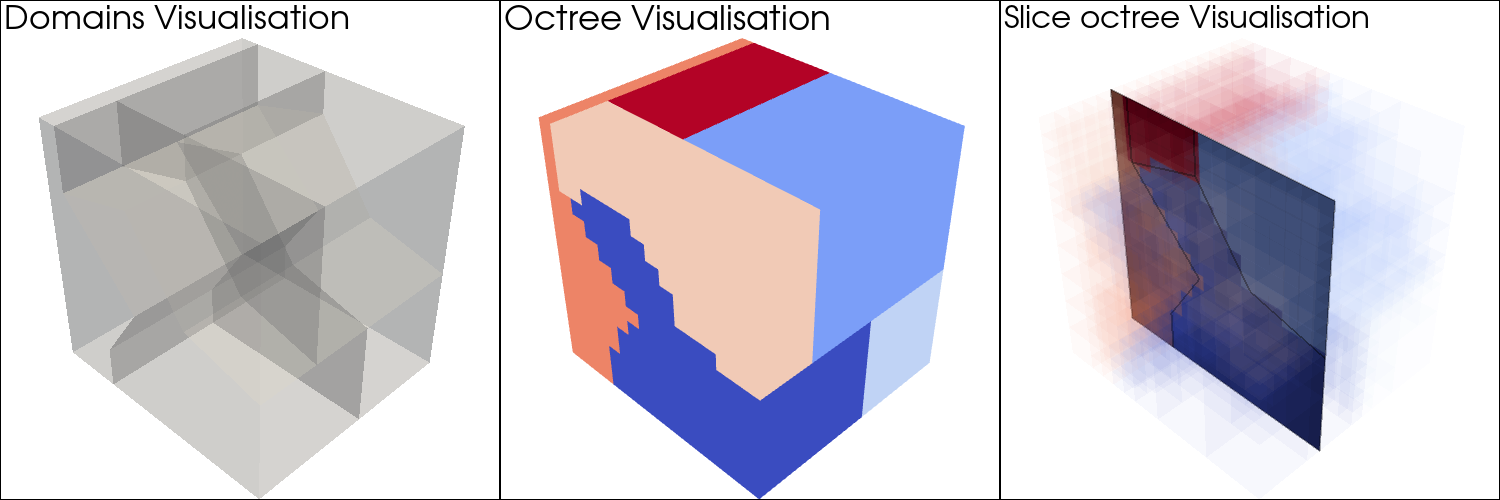

In [7]:
from sources.functions import plot_octreeAndDomains
path = os.getcwd()
pathFolder = os.getcwd()+"/Tmp"
if not os.path.isdir(pathFolder) :
    os.mkdir(pathFolder)
plot_octreeAndDomains(pathFolder,system)